# Plot Maps of ROH sharing.
Use basemap to create nice visualizations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os  # For Saving to Folder
import pandas as pd
from scipy.stats import binned_statistic  # For Binning

import matplotlib.cm as cm
import matplotlib.colorbar as clb
import matplotlib.colors as cls
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap

import socket
import os as os
import sys as sys
import multiprocessing as mp

### Square Root Scale
import matplotlib.scale as mscale
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Important Functions
For plotting ROH maps in Basemap as well as modifying/extracting the results dataframes

In [2]:
def plot_continent(df, crs=[30, 60, -10, 40], s=40, vrange=[0, 400], cmap="hot_r", fs_label=14, figsize=(12,11),
                   states=True, annotate=False, fs_labels=14, ew=0.5, y_off=1, title="", vrange_a=[], mm=3.1,
                   savepath="", dpi=300): 
    """Plot a continent, based on coordinates in df
    df: Pandas Datframe with lat lon column
    crs: [4], Corners of plot (lat and then lon)
    vrange: Normalization range for color [cM]
    shiftlong: Add to longitude (in cases for map on South America)
    vrange_a: The Age Range to Plot"""
    col_cont, col_lake = "#d9d9d9", "#d9d9d9"  # Colors for Map
    fs = 18
    #fs_labels=14
    lon, lat = df["lon"].values, df["lat"].values
    
    
    colors = df["sum_roh"]  ### Plot based on sum roh
    cmap = cm.get_cmap(cmap)
    norm = plt.Normalize(vrange[0], vrange[1]) 
    
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=[12,1]) # Third axis is just to get space!
    ax = plt.subplot(gs[0]) # The upper subplot
    ax1 = plt.subplot(gs[1]) # The lower one
    
    gs.update(wspace=0.0, hspace=0.02) # set the spacing between axes.

    m = Basemap(projection='merc', llcrnrlat=crs[0], urcrnrlat=crs[1],\
                llcrnrlon=crs[2], urcrnrlon=crs[3], resolution='i', ax=ax)  # mill

    m.fillcontinents(color=col_cont, zorder=0, lake_color=col_lake)
    #m.etopo(scale=0.5, alpha=0.4)  # if topological map
    m.drawcoastlines(color='gray', zorder=0)
    m.drawcountries(color="dimgray")
    
    if states==True:
        m.drawstates()
        
    ### Convert lat/lon to the plot coordinates
    #lon = m.shiftdata(lon, lon_0=0) # Shift Longitudes so that plotted (-180,180 around lon0)
    coords = np.array([m(lon[i],lat[i]) for i in range(len(lon))])
    x,y = np.array(coords[:,0]), np.array(coords[:,1])

    ax.scatter(x, y, c=colors, ec="k", s=s, lw=ew, cmap=cmap, norm=norm, zorder=3)
    #m.scatter(lon, lat, latlon=True, c=colors, ec="k", s=s, lw=ew, cmap=cmap, norm=norm)
    
    if len(vrange_a)>0:
        cmap_a = cm.get_cmap("binary")    # viridis_r COlor Map for the Agee
        norm_a = plt.Normalize(vrange_a[0], vrange_a[1])
        ax.scatter(x, y, c=df["age"].values, ec="k", s=s*mm, lw=ew, zorder=2, cmap=cmap_a, norm=norm_a)
        
        sm = plt.cm.ScalarMappable(cmap=cmap_a, norm=norm_a)
        sm.set_array([])
        #cax = fig.add_axes([0.05, 0.05, 0.3, 0.4]) # Make internal Axis
        divider = make_axes_locatable(ax)  # So partof Axis can be split off
        cax = divider.append_axes('right', size='6%', pad=0.07)
        fig.colorbar(sm, cax=cax, orientation='vertical')
        cax.set_ylabel('Age BP [y]', fontsize=fs_label, labelpad=0, rotation=270)
    
    if annotate:
        for i, txt in enumerate(df["clst"]):
            ax.text(x[i], y[i]+y_off, txt, fontsize=fs_labels, zorder=1, ha="center", clip_on=True)
    
    if len(title)>0:
        ax.set_title(title, fontsize=fs_labels)
    
    # Do the colorbar
    plot_colorbar(ax1, fs_label=fs_label, cmap=cmap, norm=norm)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=dpi)
        print(f"Saved to {savepath}")
    plt.show()
    
    
def plot_colorbar(ax1, fs_label, cmap, norm, tot_len=3539.39):
    """Code for plotting the colorbar"""
    cb1 = clb.ColorbarBase(ax1, cmap=cmap,
                           norm=norm, orientation='horizontal') # For the /1e3 format
    cb1.ax.tick_params(axis='x', direction='in', labelsize=fs_label)
    ax1.set_xlabel('Sum Indiviual ROH >4cM [cM]', fontsize=fs_label, rotation=0, labelpad=10)
    
    ### Set the Ticks for various degrees of Relatives:
    ticks = [tot_len/16, tot_len/64]
    labels = ["Full 1st Cousin", "Full 2nd Cousin"]
    
    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())
    
    ax2.set_xticks(ticks)
    ax2.set_xticklabels(labels)
    ax2.tick_params(axis='x', direction='in', labelsize=fs_label, pad=-fs_label*1.5)

    
def prepare_coordinates_square(lat, lon, ofst_lat=0.1, ofst_lon=0.2):
    """Prepare and return coordinates in a square"""
    assert(len(lat)>0)   # Sanity Check
    n = len(lat)
    ints = np.array(range(n))
    r = np.ceil(np.sqrt(n)) # What's the maximum width
    hor = ints % r
    ver = np.floor(ints / r)
    
    # Apply the Correction
    lon_new = lon + hor * ofst_lon - (r-1)/2 * ofst_lon
    lat_new = lat - ver * ofst_lat + (r-1)/2 * ofst_lat
    
    return lat_new, lon_new

def prepare_coordinates_df(df, ofst_lat=0.1, ofst_lon=0.2):
    """Create coordinates in a new Dataframe, based on matching groups of coordinates"""
    gp = df.groupby(['lat','lon'])
    gp_idcs = list(gp.indices.values())  # Get list of list of Indices

    df_plot = df.copy(deep=True)  # Make a Deep Copy for modifying GPS

    ### Modify all Lat/Lon Indices
    for i, idcs in enumerate(gp_idcs[:]):  # Go over all Group Indices
        x = df.iloc[idcs][["lat", "lon"]]
        lat, lon =  df.iloc[idcs]["lat"], df.iloc[idcs]["lon"]
        lat, lon = prepare_coordinates_square(lat.values, lon.values, 
                                              ofst_lat=ofst_lat, ofst_lon=ofst_lon)

        df_plot["lat"].iloc[idcs] = lat
        df_plot["lon"].iloc[idcs] = lon
    return df_plot

class SquareRootScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square root scale.
    """
    name = 'squareroot'

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self, axis=axis)   # Version Cluster
        #mscale.ScaleBase.__init__(self)   # Version Harald Laptop old matplotlib

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax

    class SquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, a): 
            return np.array(a)**0.5

        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()

    class InvertedSquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform(self, a):
            return np.array(a)**2

        def inverted(self):
            return SquareRootScale.SquareRootTransform()

    def get_transform(self):
        return self.SquareRootTransform()

mscale.register_scale(SquareRootScale)

In [3]:
def extract_df_geo(df, lat0, lat1, lon0, lon1):
    """Extract Dataframe df from Sub Data frame based on coordinates
    lat0,lat1: Min and Max Lat. Equ. for lon0,lon1"""
    lat_okay = (df["lat"]>lat0) & (df["lat"]<lat1)
    lon_okay = (df["lon"]>lon0) & (df["lon"]<lon1)
    df_s = df[lat_okay & lon_okay]
    return df_s

def extract_df_age(df, age0, age1):
    """Extract Dataframe based on age.
    df: Input Dataframe; age0 and age1 min and max age"""
    age_okay = (df["age"]>=age0) & (df["age"]<=age1)
    df = df[age_okay]
    return df

def clean_roh_df(df1, age_cutoff=15000, iids_del = ["Loschbour_snpAD.DG", "I0001"]):
    """Clean a ROH Dataframe to only values with geographic data (and below age).
    Also remove some duplicate samples based on iid"""
    df1 = df1[~np.isnan(df1["lat"])]
    df1 = df1[~np.isnan(df1["lon"])]
    print(f"Filtered to {len(df1)} Individuals with existing Lat/Lon values")
    df1 = df1[df1["age"]<age_cutoff]
    print(f"Filtered to {len(df1)} Individuals with Age < {age_cutoff}")
    
    del_idx = df1["iid"].isin(iids_del)
    df1 = df1[~del_idx]
    print(f"Filtered to {len(df1)} unique Individuals")
    return df1

### Load Data
1. full meta_df and 
2. HO results meta

In [ ]:
### Load the relevant Data
meta_path = "./Data/Marcus2019_1240k/meta_rev_unique_ids.csv"
df_meta = pd.read_csv(meta_path)
df_ho = df_meta[df_meta["study"]=="Lazaridis et al. 2014"]

In [4]:
### Load HAPSBURG results
ho_results_path = "./Empirical/HO/CombinedROH/combinedroh.csv"
df_roh = pd.read_csv(ho_results_path, sep='\t')

In [100]:
df_roh[df_roh["pop"]=="Karitiana"]

,iid,pop,max_roh,sum_roh,n_roh,lat,lon,age
1,Karitiana_11,Karitiana,71.722305,617.914425,37,-10.0,-63.0,0.0
24,Karitiana_6,Karitiana,45.313498,391.608298,26,-10.0,-63.0,0.0
26,Karitiana_8,Karitiana,64.847401,385.001179,25,-10.0,-63.0,0.0
38,Karitiana_10,Karitiana,82.006193,339.903583,30,-10.0,-63.0,0.0
64,Karitiana_1,Karitiana,49.881899,271.734296,23,-10.0,-63.0,0.0
67,Karitiana_9,Karitiana,22.559301,269.280127,28,-10.0,-63.0,0.0
71,Karitiana_3,Karitiana,28.113000,260.162700,21,-10.0,-63.0,0.0
86,Karitiana_4,Karitiana,28.001595,238.774982,21,-10.0,-63.0,0.0
90,Karitiana_7,Karitiana,29.875001,233.929186,22,-10.0,-63.0,0.0
146,Karitiana_0,Karitiana,21.097201,159.277600,19,-10.0,-63.0,0.0


## World Wide Plot of all HO samples

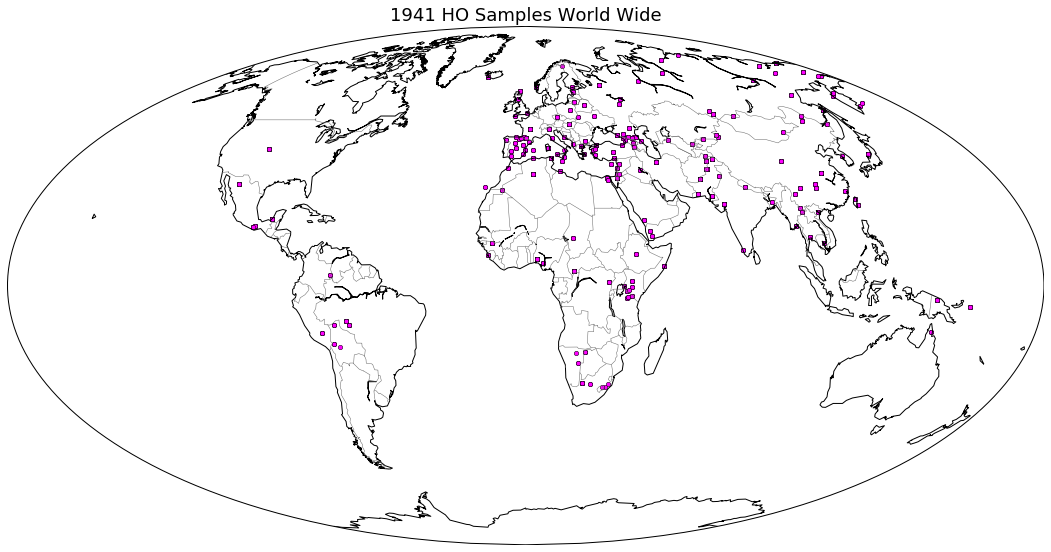

In [101]:
fs = 18
lat=df_roh["lat"].values
lon=df_roh["lon"].values

fig = plt.figure(figsize=(18,12))
ax=fig.add_axes([0.1,0.1,0.8,0.8])

#m = Basemap(projection='cyl',llcrnrlat=-60,urcrnrlat=85, 
#                llcrnrlon=-180,urcrnrlon=180,resolution='c')

m = Basemap(projection='moll', lat_0=0, lon_0=0)

m.drawcoastlines()
#m.drawparallels(np.arange(-90,90,30),labels=[1,1,0,1], fontsize=8)
#m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1], rotation=45, fontsize=8)
#m.etopo(scale=0.5, alpha=0.4)  # if topological map
m.drawcoastlines(color='gray', zorder=0)
m.drawcountries(color="dimgray")
#m.drawstates()

plt.title(f"{len(lon)} HO Samples World Wide", fontsize=fs)
m.scatter(lon, lat, latlon=True, c="magenta", ec="k", s=20, lw=0.5) #cmap=cmap0, norm=norm0
#          c=df_plot["ages"].values, alpha=0.8, s=25, edgecolors='k', linewidths=0.3)

#plt.colorbar(label="Age [ky BP]", shrink=0.5)
#fig.savefig("", dpi=200, bbox_inches = 'tight', pad_inches = 0)
#plt.close(fig)

plt.show()

### Plot Europe with splitting up samples

Saved to ./figures/poster_probgen19/eur_ho_map.png


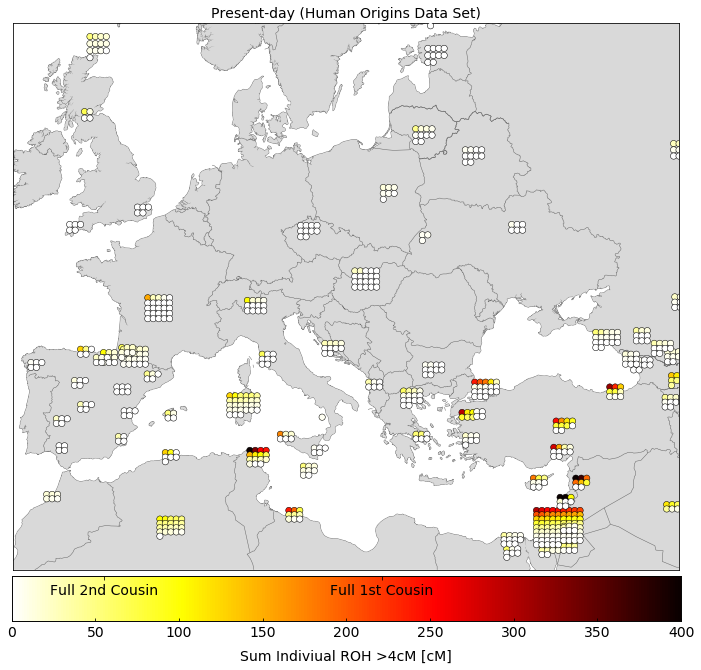

In [106]:
#df_plot = prepare_coordinates_df(df_roh, ofst_lat=0.3, ofst_lon=0.45)
plot_continent(df_plot, crs=[29, 60, -10, 45], savepath="./figures/poster_probgen19/eur_ho_map.png", dpi=100,
              title="Present-day (Human Origins Data Set)")

/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


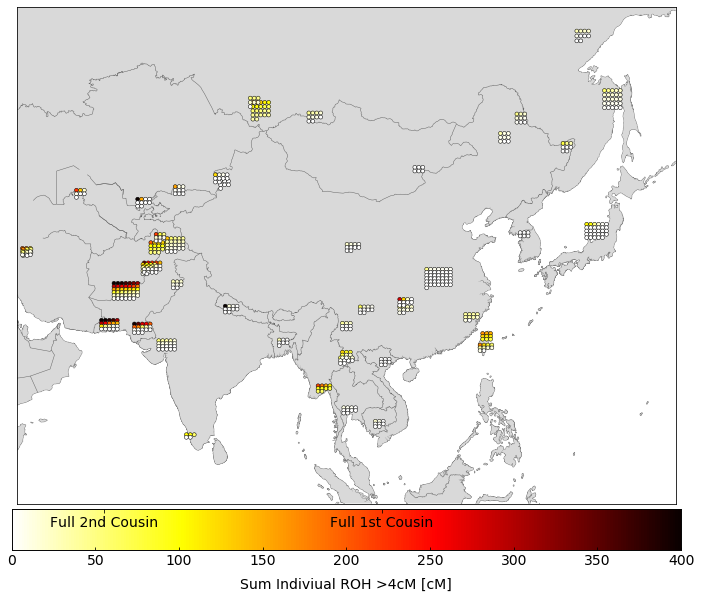

In [5]:
### Do the same for Asia
df_plot = prepare_coordinates_df(df_roh, ofst_lat=0.4, ofst_lon=0.6)
plot_continent(df_plot, crs=[0, 60, 50, 150], s=15, figsize=(12,10))

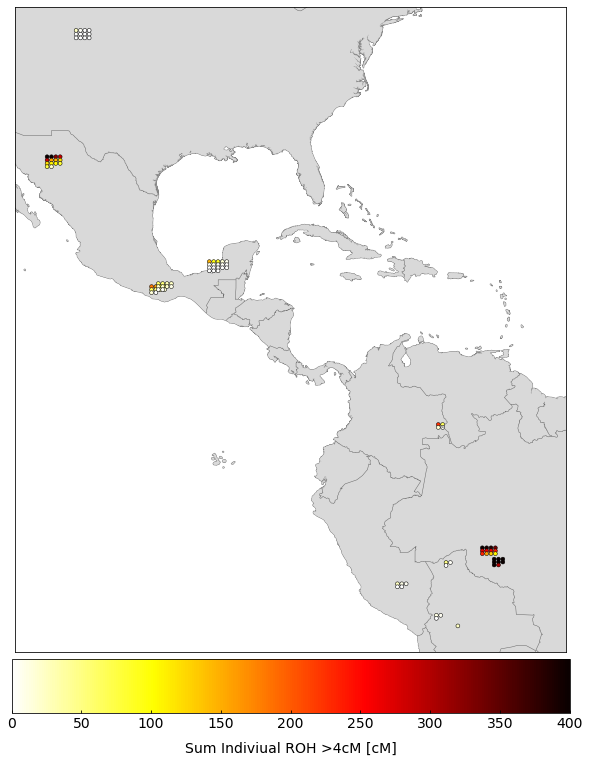

In [362]:
plot_continent(df_plot, crs=[-20, 42, 248, 305], s=15, figsize=(10,13), states=False)

# Plot ROH from Reich Sample (ancients)
Need Plotting functino and Imports from above

In [5]:
### Then apply some filters
age_cutoff=15000


### First load the Data
df1 = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", '\t')
print(f"Loaded {len(df1)} Individuals")

df1 = df1[~np.isnan(df1["lat"])]
df1 = df1[~np.isnan(df1["lon"])]
print(f"Filtered to {len(df1)} Individuals with existing Lat/Lon values")
df1 = df1[df1["age"]<age_cutoff]
print(f"Filtered to {len(df1)} Individuals with Age < {age_cutoff}")
#df_plot = prepare_coordinates_df(df1, ofst_lat=0.3, ofst_lon=0.45)

Loaded 1098 Individuals
Filtered to 988 Individuals with existing Lat/Lon values
Filtered to 966 Individuals with Age < 15000


In [5]:
df_plot = prepare_coordinates_df(df1, ofst_lat=0.8, ofst_lon=1.0)  # Spacing adequate for South America

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


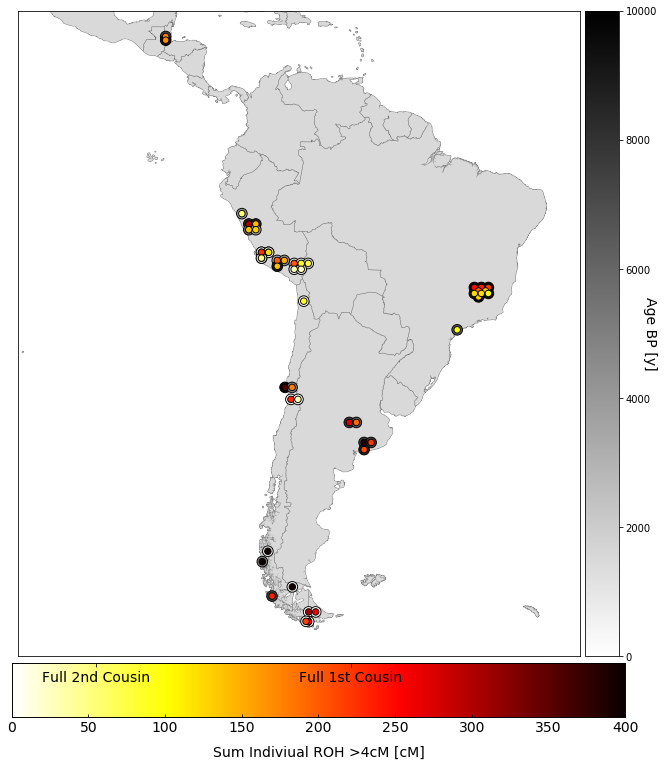

In [39]:
plot_continent(df_plot, crs=[-58, 20, -110, -30], s=42, figsize=(11,13), states=False,
               annotate=False, fs_labels=8, ew=0.9, y_off=1e5, vrange_a=[0,10000], mm=2.7)

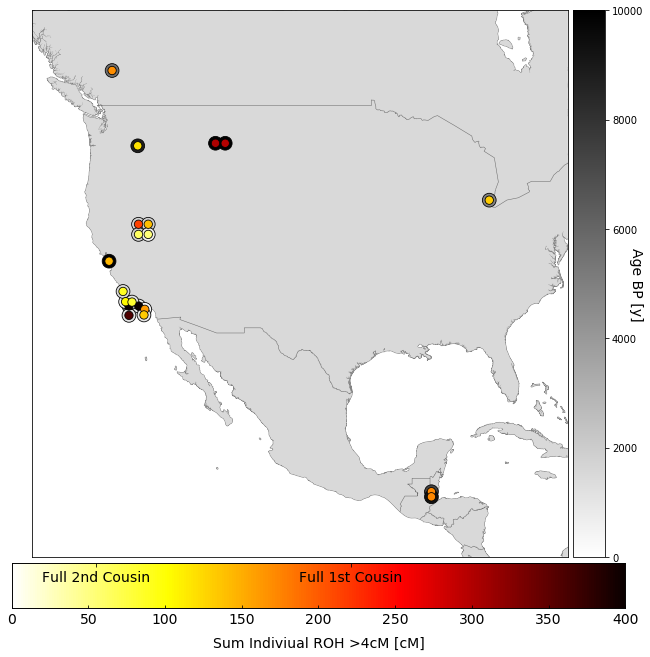

In [42]:
plot_continent(df_plot, crs=[10, 55, -130, -75], s=70, figsize=(11,11), states=False,
               annotate=False, fs_labels=8, ew=0.8, vrange_a=[0,10000], mm=2.7)

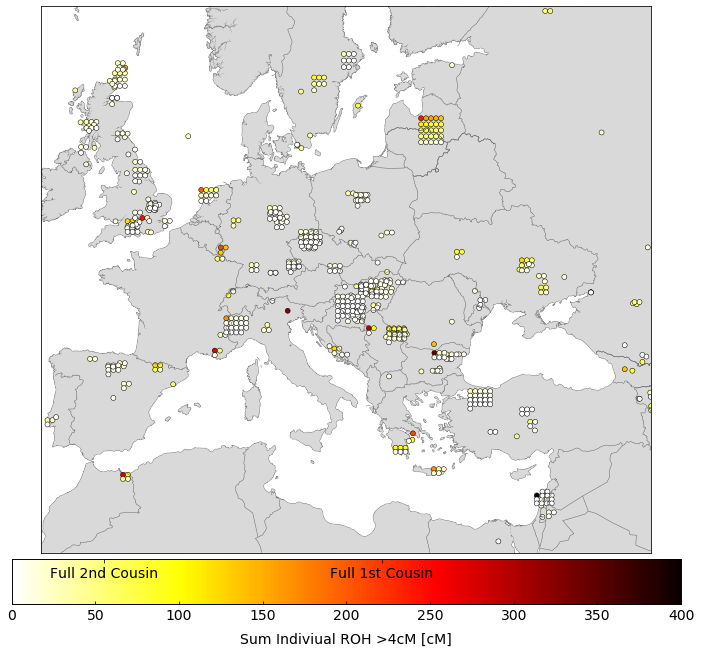

In [12]:
#df_plot = prepare_coordinates_df(df1, ofst_lat=0.3, ofst_lon=0.45)
plot_continent(df_plot, crs=[29, 62, -10, 45], s=25)
#plot_continent(df_plot, crs=[30, 40, 30, 40], s=30)

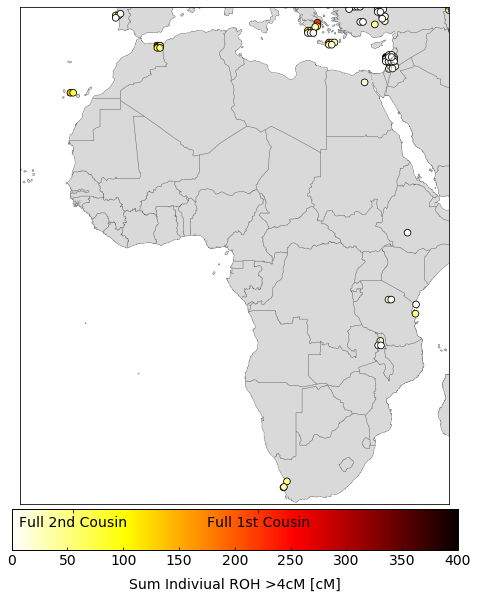

In [25]:
plot_continent(df_plot, crs=[-35, 40, -25, 45], s=45, figsize=(8,10), ew=0.8)

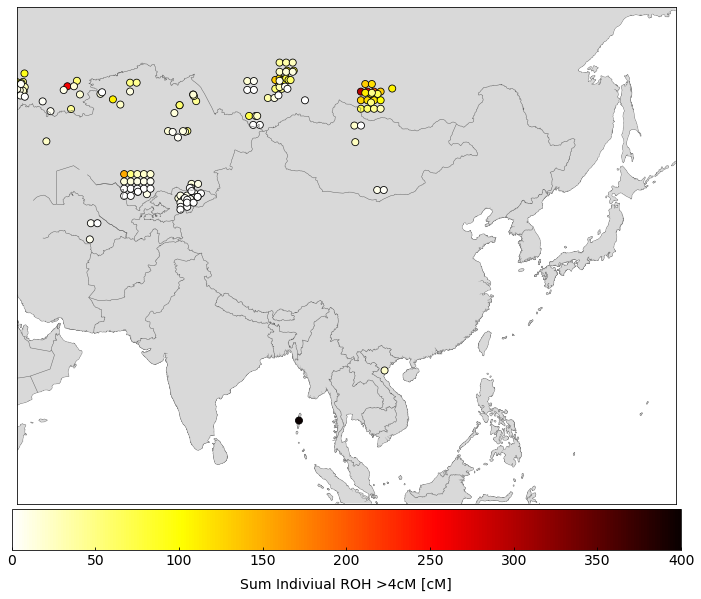

In [23]:
plot_continent(df_plot, crs=[0, 60, 50, 150], s=50, figsize=(12,10),
               annotate=False, fs_labels=14, ew=0.8)

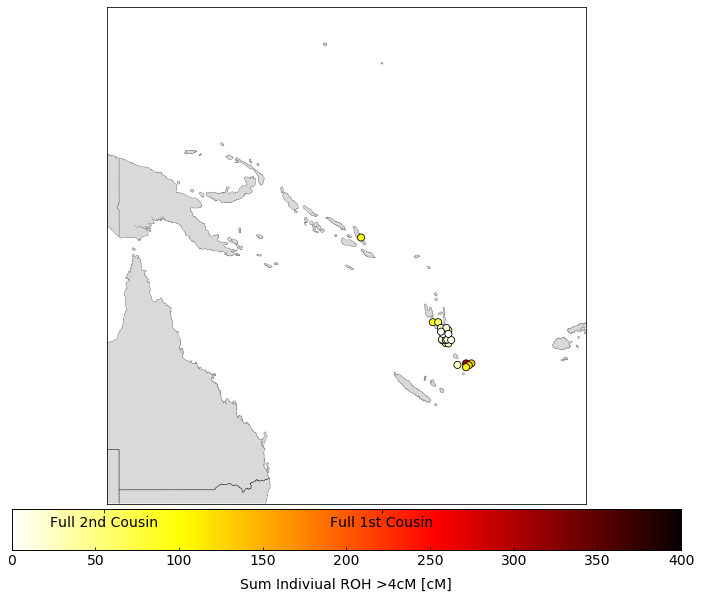

In [8]:
plot_continent(df_plot, crs=[-30, 10, 140, 180], s=50, figsize=(12,10),
               annotate=False, fs_labels=14, ew=0.8)

## Plot Subregion and Subtime

### European HGs:

In [6]:
df_euro = extract_df_geo(df1, 29, 62, -10, 45)
df_euro_old = extract_df_age(df_euro, 7000, 25000)

In [69]:
substrings = ["HG", "Mesolithic", "Villabruna", "ElMiron", "Bichon", "Loschbour_published"]
hg = df_euro_old["clst"].str.contains('|'.join(substrings))
df_hg = df_euro_old[hg]
#df_hg.sort_values(by="age")[:50]
len(df_hg)

59

Saved to ./figures/poster_probgen19/eur_hg_map.png


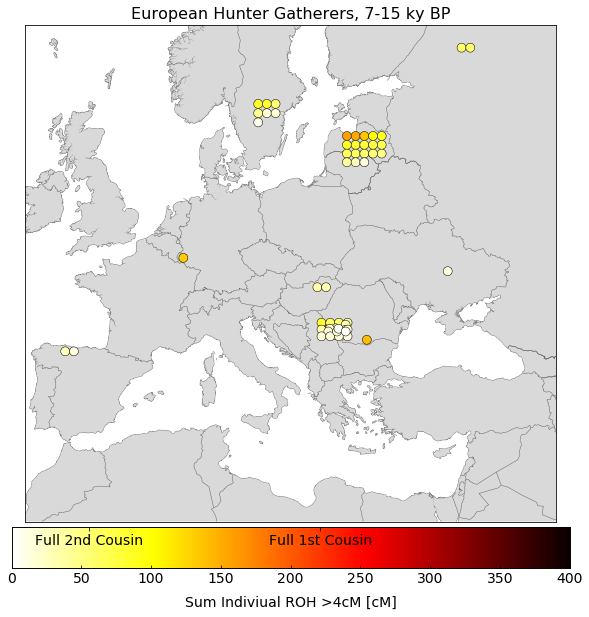

In [90]:
#df_plot = prepare_coordinates_df(df_hg, ofst_lat=0.5, ofst_lon=0.9)
plot_continent(df_plot, crs=[29, 63, -10, 45], s=80, title="European Hunter Gatherers, 7-15 ky BP", fs_labels=16,
               savepath="./figures/poster_probgen19/eur_hg_map.png", figsize=(10,10), dpi=100)
#vrange_a=[7000,15000] , mm=2.7

### Early European Farmers (7ky - 12ky BP)

In [91]:
df_euro = extract_df_geo(df1, 29, 62, -10, 45)
df_euro_old = extract_df_age(df_euro, 6000, 9000)

substrings = ["N", "farmer"]
neo = df_euro_old["clst"].str.contains('|'.join(substrings))
df_neo = df_euro_old[neo]
len(df_neo)

121

Saved to ./figures/poster_probgen19/eur_eef_map.png


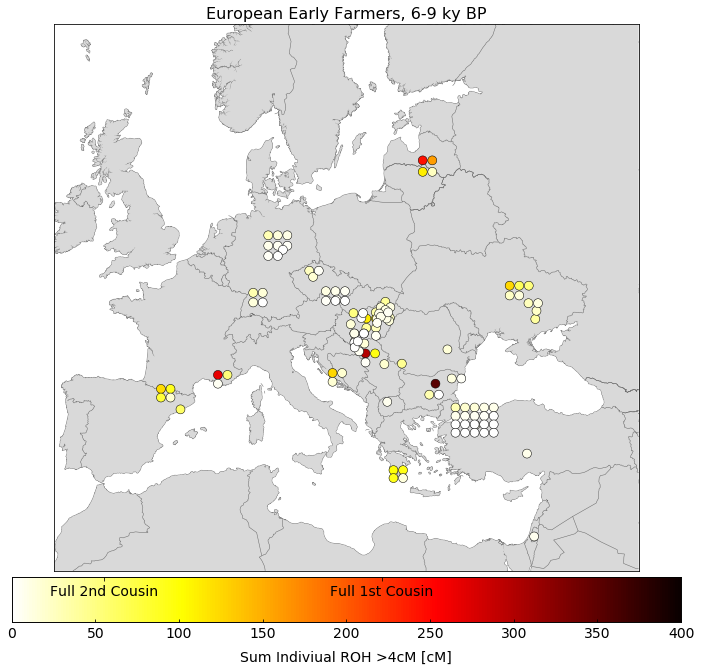

In [93]:
df_plot = prepare_coordinates_df(df_neo, ofst_lat=0.6, ofst_lon=0.9)
plot_continent(df_plot, crs=[29, 63, -10, 45], s=80, title="European Early Farmers, 6-9 ky BP",
              fs_labels=16, savepath="./figures/poster_probgen19/eur_eef_map.png", dpi=100)
#vrange_a=[6000,9000], mm=2.7

### European Bronze Age

In [95]:
df_euro = extract_df_geo(df1, 29, 62, -10, 45)
df_euro_young = extract_df_age(df_euro, 2800, 6000)

substrings = ["BA", "Beaker", "Mycenaean", "Minoan"]
ba = df_euro_young["clst"].str.contains('|'.join(substrings))

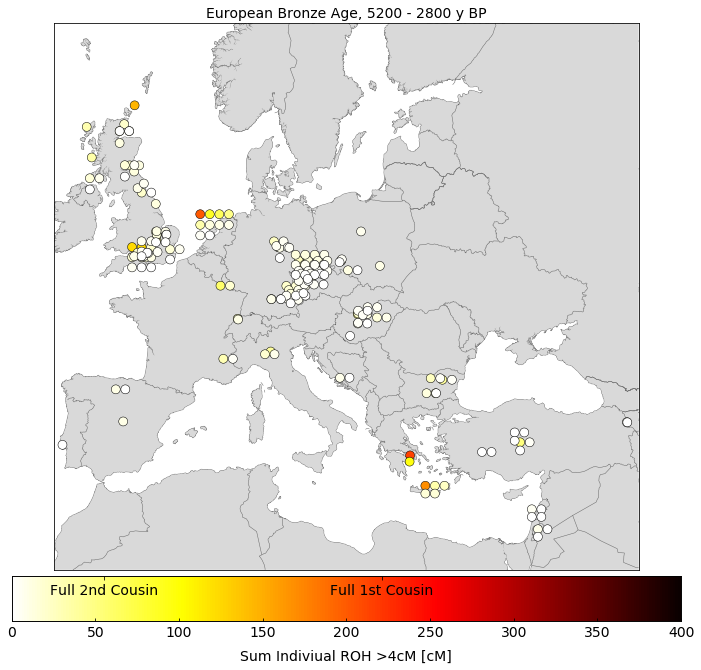

In [97]:
df_plot = prepare_coordinates_df(df_euro_young[ba], ofst_lat=0.6, ofst_lon=0.9)
plot_continent(df_plot, crs=[29, 63, -10, 45], s=80, title="European Bronze Age, 5200 - 2800 y BP", dpi=100)
# vrange_a=[2800,6000], mm=2.7

### European Recent

In [65]:
df_euro = extract_df_geo(df1, 29, 62, -10, 45)
df_euro_young = extract_df_age(df_euro, 0, 2800)
len(df_euro_young)

99

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


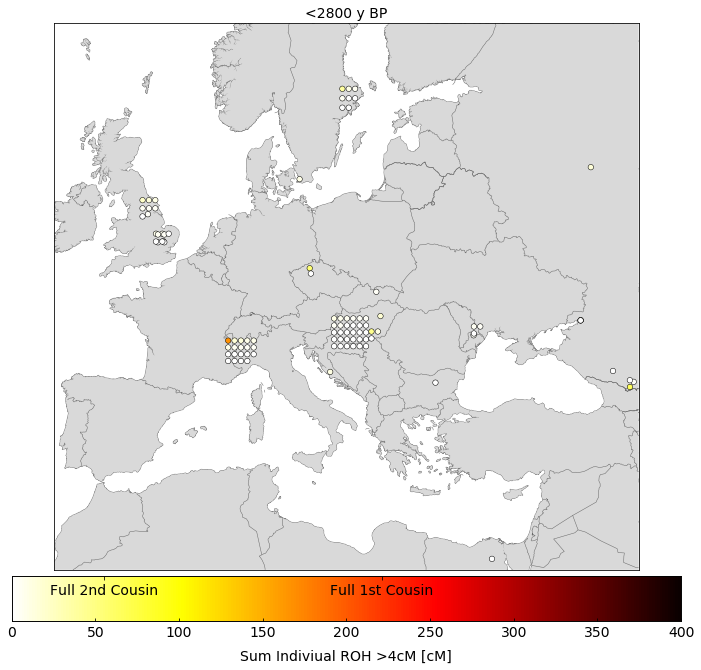

In [66]:
df_plot = prepare_coordinates_df(df_euro_young, ofst_lat=0.45, ofst_lon=0.6)
plot_continent(df_plot, crs=[29, 63, -10, 45], s=30, title="<2800 y BP")  #vrange_a=[0,2800], mm=2.7

### Plot Yamnaya, Corded Ware

In [202]:
#substrings = ["BA", "Beaker", "Mycenaean", "Minoan"]
df_euro = extract_df_geo(df1, 29, 62, -10, 45)
df_euro_young = extract_df_age(df_euro, 2800, 7000)
substrings = ["Corded_Ware", "CW", "Yamn", "Steppe", "Beaker"]
#substrings = ["Beaker"]
cw = df_euro_young["clst"].str.contains('|'.join(substrings))

/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


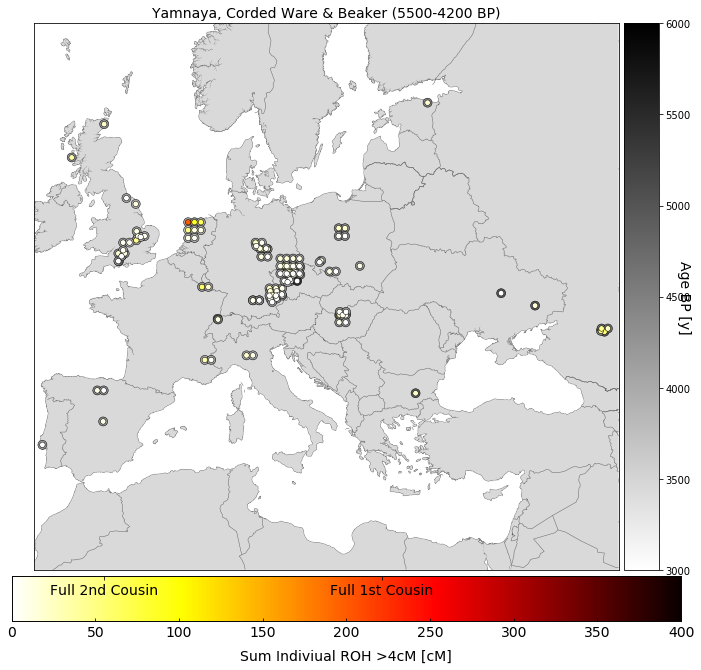

In [203]:
df_plot = prepare_coordinates_df(df_euro_young[cw], ofst_lat=0.45, ofst_lon=0.6)
plot_continent(df_plot, crs=[29, 63, -10, 45], s=30, title="Yamnaya, Corded Ware & Beaker (5500-4200 BP)",vrange_a=[3000,6000], mm=2.7)

# Plot ROH vrs Age
Standalone from here on (besides overall imports and functions in beginning)

In [107]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [124]:
### First load the Data
df1 = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", '\t')
print(f"Loaded {len(df1)} Individuals")

df1.loc[df1["iid"]=="Aconcagua.SG", "lat"] = -32.65  # Flip Wrong Latitude (32.64 is in Atlantic)
df1 = clean_roh_df(df1, age_cutoff=14000)

#df_euro = extract_df_geo(df1, 29, 62, -10, 45).copy()  # Make a new Copy. EUrope
df_euro = extract_df_geo(df1, -60, 55, -130, -30).copy()  # Make a new Copy. America
#df_euro = extract_df_geo(df1, 49, 60, -12, 3).copy()  # Make a new Copy. Great Britain

print(f"Extracted {len(df_euro)} European Individuals")
df_euro["color"]="darkgray"

Loaded 1098 Individuals
Filtered to 988 Individuals with existing Lat/Lon values
Filtered to 962 Individuals with Age < 14000
Filtered to 960 unique Individuals
Extracted 68 European Individuals


In [125]:
def lowess_sqrt(x,y, frac=2/3):
    """Do a Lowess fitting on the sqrt"""
    y=np.sqrt(y)
    z = lowess(y, x, frac=frac)
    z[:,1]=z[:,1]**2
    return z

### Do the whole Data
x=df_euro["age"].values
y=df_euro["sum_roh"].values
c=df_euro["color"]
z = lowess_sqrt(x, y)
#w = lowess(y, x, frac=1./3)


### Do the Hunter Gatherers samples
substrings = ["HG", "Mesolithic", "Villabruna", "ElMiron", "Bichon", "Loschbour"]
hg = df_euro["clst"].str.contains('|'.join(substrings))
df_hg = df_euro[hg]
df_hg = df_hg[df_hg["age"]>6000]
print(f"Extracted {len(df_hg)} HGs")

x_hg = df_hg["age"].values
y_hg = df_hg["sum_roh"].values
z_hg = lowess_sqrt(x_hg, y_hg, frac=1)


### Do the EEFs
substrings = ["N", "farmer"]
df_t = extract_df_age(df_euro, 3000, 9000)
neo = df_t["clst"].str.contains('|'.join(substrings))
neth = df_t["clst"].str.startswith("Nether")
df_neo = df_t[neo&(~neth)]
print(f"Extracted {len(df_neo)} Neolithic Individuals")

x_neo = df_neo["age"].values
y_neo = df_neo["sum_roh"].values
z_neo = lowess_sqrt(x_neo, y_neo, frac=1)

### Do BA
df_t = extract_df_age(df_euro, 2800, 7000)
substrings = ["Corded_Ware", "CW", "Yamn", "Steppe", "Beaker"]
#substrings = ["Beaker"]
cw = df_t["clst"].str.contains('|'.join(substrings))
df_b = df_t[cw]
print(f"Extracted {len(df_b)} BA Individuals")

x_b = df_b["age"].values
y_b = df_b["sum_roh"].values
z_b = lowess_sqrt(x_b, y_b, frac=1)

Extracted 0 HGs
Extracted 1 Neolithic Individuals
Extracted 0 BA Individuals


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/harald/.local/lib/python3.6/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


In [126]:
def plot_lowess_smoothing(savepath="", fs=14, fsl=10, tot_l=3539.39, plot_substruct=True,
                         figsize=(12,6), title="", dpi=300):
    """Plot Lowess Smoothing of ROH vrs Age.
    plot_substruct: Whether to plot the three different periods"""

    plt.figure(figsize=figsize)
    ax = plt.gca()
    plt.scatter(x, y, c=c, edgecolor="k", s=30)
    plt.plot(z[:,0], z[:,1], "k-", label=r"Lowess Smoothing ($\sqrt{x}$)", lw=3)

    if plot_substruct:
        ### Do HG
        plt.scatter(x_hg, y_hg, c="red", ec="k", s=30, label="Hunter Gatherer")
        plt.plot(z_hg[:,0], z_hg[:,1], "r-", lw=2)

        ### Do Farmers
        plt.scatter(x_neo, y_neo, c="blue", ec="k", s=30, label="Farmers")
        plt.plot(z_neo[:,0], z_neo[:,1], "b-", lw=2)

        ### Do BA
        plt.scatter(x_b, y_b, c="green", s=30, ec="k", label="Yamnaya/CW/Beaker")
        plt.plot(z_b[:,0], z_b[:,1], "g-", lw=2)


    ### Do the horizontal Lines
    ticks = [tot_l/16, tot_l/64]

    ax.set_ylim([0,800])
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yscale('squareroot')
    ax2.set_yticks(ticks)
    ax2.set_yticklabels(["1st C.", "2nd C."])
    for t in ticks:
        ax.axhline(t, color="gray", lw=0.5, ls="--")
    ax2.tick_params(axis='y', direction='in', labelsize=fsl, pad=5)

    ax.set_xlabel("Age BCE [years]", fontsize=fs)
    ax.set_ylabel("Sum ROH >4 cM [cM]", fontsize=fs)

    ax.invert_xaxis()
    ax.set_yscale('squareroot')
    #plt.ylim([0, 800])

    ax.legend(loc="upper right", fontsize=fsl)
    if len(title)>0:
        ax.set_title(title, fontsize=fs)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=dpi)
        print(f"Saved to {savepath}")
    plt.show()

Saved to ./figures/poster_probgen19/europe_roh_timeseries.png


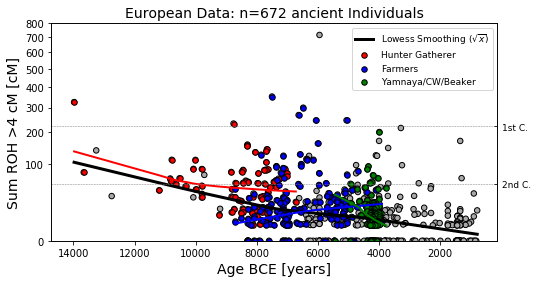

In [121]:
plot_lowess_smoothing(title=f"European Data: n={len(df_euro)} ancient Individuals", figsize=(8,4), fsl=9,
                      savepath="./figures/poster_probgen19/europe_roh_timeseries.png")

Saved to ./figures/poster_probgen19/america_roh_timeseries.png


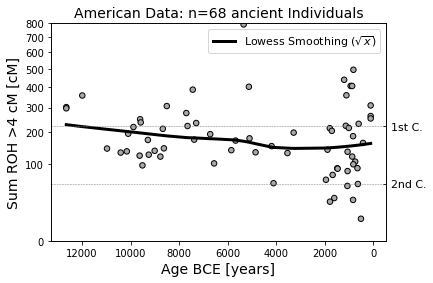

In [127]:
plot_lowess_smoothing(title=f"American Data: n={len(df_euro)} ancient Individuals", figsize=(6,4), fsl=11,
                     savepath="./figures/poster_probgen19/america_roh_timeseries.png", plot_substruct=False)

In [129]:
substrings = ["Stuttgart", "Loschbour"]
hg = df_euro["clst"].str.contains('|'.join(substrings))
df_hg = df_euro[hg]

In [130]:
df_hg

,iid,max_roh,sum_roh,n_roh,lat,lon,age,study,clst,mean_cov,n_cov_snp,include_alt,color
58,I0001,13.316798,208.331492,37,49.81,6.40,8050.0,MathiesonNature2018,Luxembourg_Loschbour,2.988,464995,1,darkgray
88,Loschbour_snpAD.DG,13.304102,141.666407,22,49.81,6.40,8050.0,Pruefer2017,Luxembourg_Loschbour.DG,22.000,1062011,1,darkgray
101,Loschbour_published.DG,13.295603,132.804321,19,49.81,6.40,8050.0,LazaridisNature2014,Luxembourg_Loschbour_published.DG,22.000,1139327,1,darkgray
498,Stuttgart_published.DG,12.571705,16.738309,2,48.78,9.18,7140.0,LazaridisNature2014,Germany_LBK_EN_Stuttgart_published.DG,19.000,1130723,1,darkgray


In [135]:
substrings = ["Loschbour_snpAD.DG","I0001"]
#substrings = ["I0001", "Loschbour_snpAD.DG"]
hg = df_euro["iid"].isin(substrings)
df_hg = df_euro[hg]

In [136]:
df_hg

,iid,max_roh,sum_roh,n_roh,lat,lon,age,study,clst,mean_cov,n_cov_snp,include_alt,color
58,I0001,13.316798,208.331492,37,49.81,6.4,8050.0,MathiesonNature2018,Luxembourg_Loschbour,2.988,464995,1,darkgray
88,Loschbour_snpAD.DG,13.304102,141.666407,22,49.81,6.4,8050.0,Pruefer2017,Luxembourg_Loschbour.DG,22.000,1062011,1,darkgray


### Make Plot of South American vrs Age (maybe contrasting Europe)

# Area 51
Test Code here 

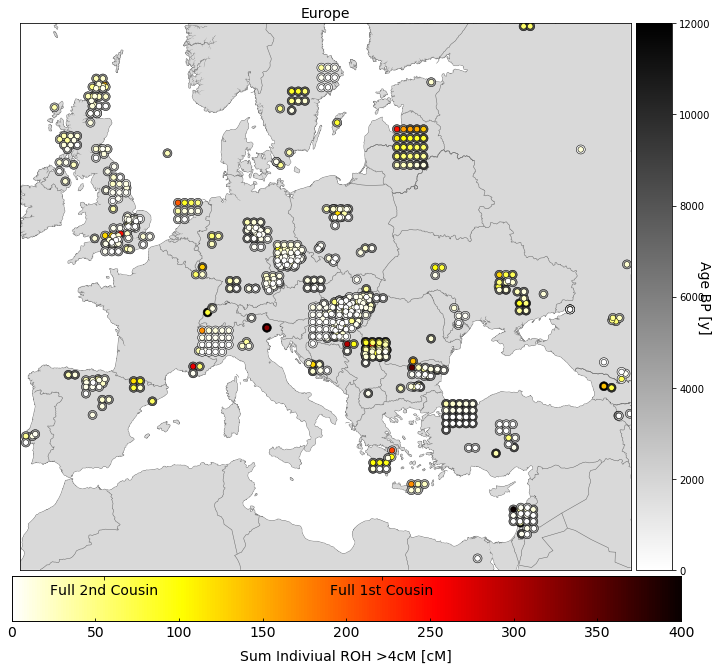

In [220]:
#df_plot = prepare_coordinates_df(df_euro, ofst_lat=0.45, ofst_lon=0.6)
#plot_continent(df_plot, crs=[49, 60, -12, 3], s=30, title="Great Britain",vrange_a=[0,9000], mm=2.7)
plot_continent(df_plot, crs=[29, 62, -10, 45], s=30, title="Europe",vrange_a=[0,12000], mm=2.7)


# Make South America (Plot for Poster Probgen)

Saved to ./figures/poster_probgen19/sa_roh.png


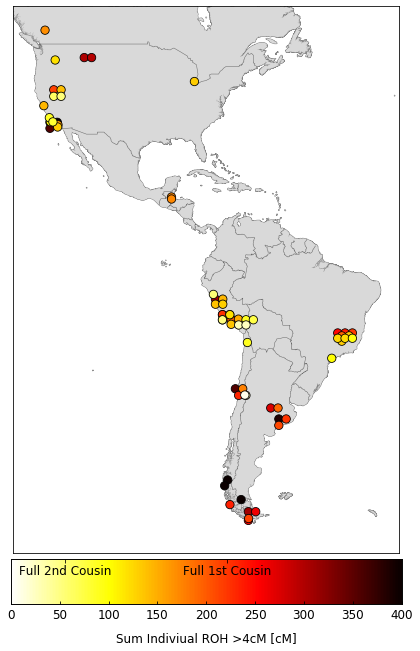

In [48]:
#df_plot = prepare_coordinates_df(df1, ofst_lat=1.3, ofst_lon=1.9)  # Spacing adequate for whole America
plot_continent(df_plot, crs=[-60, 55, -130, -30], s=70, figsize=(7, 11), states=False,
               annotate=False, fs_label=12, ew=0.8, savepath="./figures/poster_probgen19/sa_roh.png") # vrange_a=[0,10000], mm=2.7

In [37]:
df_plot.loc[df_plot["iid"]=="Aconcagua.SG","lat"] # Check whether flipper

683   -32.65
Name: lat, dtype: float64

In [172]:
#substrings = ["BA", "Beaker", "Mycenaean", "Minoan"]
df_euro = extract_df_geo(df1, 29, 62, -10, 45)
df_euro_young = extract_df_age(df_euro, 2800, 7000)
substrings = ["Corded_Ware", "CW", "Yamn", "Steppe"]
cw = df_euro_young["clst"].str.contains('|'.join(substrings))

In [173]:
df_euro_young[ba].sort_values(by="age")

,iid,max_roh,sum_roh,n_roh,lat,lon,age,study,clst,mean_cov,n_cov_snp,include_alt
425,I7280,6.662906,21.669398,4,50.190000,14.158000,4200.0,OlaldeNature2018,Czech_Corded_Ware,3.362758,780479,1
405,I7279,9.432599,23.729900,3,50.190000,14.158000,4200.0,OlaldeNature2018,Czech_Corded_Ware,1.095572,636343,1
861,I1532,4.017103,4.017103,1,51.420000,11.680000,4225.0,MathiesonNature2015,Germany_Corded_Ware,0.566000,464060,1
576,I0049,4.737210,12.791812,3,51.420000,11.680000,4287.0,MathiesonNature2015 (1240k of same same sample...,Germany_Corded_Ware,0.649000,514322,1
419,I0104,6.383401,22.040411,4,51.420000,11.680000,4378.0,MathiesonNature2015 (1240k of same same sample...,Germany_Corded_Ware,4.184000,962767,1
412,N44.SG,7.037300,23.012692,4,52.620000,18.960000,4405.0,FernandesScientificReports2018,Poland_CWC_o.SG,2.185667,1017645,1
922,N49.SG,0.000000,0.000000,0,52.620000,18.960000,4405.0,FernandesScientificReports2018,Poland_CWC.SG,2.224865,1045306,1
459,N45.SG,6.720590,19.089388,4,52.620000,18.960000,4405.0,FernandesScientificReports2018,Poland_CWC.SG,2.472478,1050046,1
789,N47.SG,4.617099,4.617099,1,52.620000,18.960000,4405.0,FernandesScientificReports2018,Poland_CWC_o.SG,2.429959,1074445,1
451,MA826.RISE00.SG,6.362998,19.379504,4,59.408000,27.026000,4413.0,SaagCurrentBiology2017.merge.with.AllentoftNat...,Estonia_Corded_Ware.SG,0.799000,626916,1


In [ ]:
df_plot = prepare_coordinates_df(df_euro_young, ofst_lat=0.45, ofst_lon=0.6)
plot_continent(df_plot, crs=[29, 63, -10, 45], s=50, title="<2800 y BP")

In [134]:
#df_hg.sort_values(by="age")[:50]
df_neo.sort_values(by="age")[:]

,iid,max_roh,sum_roh,n_roh,lat,lon,age,study,clst,mean_cov,n_cov_snp,include_alt
76,I4435,25.343204,160.237615,17,56.283300,25.133300,6003.0,MathiesonNature2018,Latvia_MN,3.407000,729122,1
42,I4627,38.998098,245.086993,27,56.283300,25.133300,6064.0,MathiesonNature2018,Latvia_MN,1.770000,686273,1
388,I4436,10.644710,26.060510,3,56.283300,25.133300,6105.0,MathiesonNature2018,Latvia_MN,3.029000,751632,1
123,I4437,18.231198,111.219116,16,56.283300,25.133300,6148.0,MathiesonNature2018,Latvia_MN,3.600000,732248,1
383,I4893,16.081202,26.257306,3,50.121747,14.456951,6349.0,OlaldeNature2018,Czech_N,5.311000,836569,1
126,I1495,33.298600,110.765296,8,47.167000,19.833000,6374.0,MathiesonNature2015 (capture of same sample sh...,Hungary_Lengyel_LN,4.853000,829966,1
121,NE7.SG,24.709200,113.546918,11,47.167000,19.833000,6374.0,GambaNatureCommunications2014,Hungary_MN.SG,0.998000,749149,1
785,I4894,4.647300,4.647300,1,50.121747,14.456951,6378.0,OlaldeNature2018,Czech_N,4.046000,816890,1
469,I7197,18.570596,18.570596,1,50.050415,14.366727,6450.0,OlaldeNature2018,Czech_MN,2.767748,738450,0
28,I1131,39.993691,299.807293,21,44.900000,19.750000,6483.0,MathiesonNature2018,Serbia_EN,2.922000,776289,1


In [16]:
df_sa = extract_df_geo(df1, -90, 90, -150, -30)
df_sa = extract_df_age(df_sa, 0, 1000)

In [17]:
df_sa["study"].value_counts()

PosthNakatsukaCell2018    7
RaghavanScience2015       3
ScheibScience2018         3
MorenoMayarScience2018    2
delaFuentePNAS2018        1
Name: study, dtype: int64

In [8]:
#df_sa.to_csv("./Diverse/list_anc_am.csv", sep="\t")
len(df_sa)

69

In [23]:
df_sa[df_sa["study"]=="delaFuentePNAS2018"]

,iid,max_roh,sum_roh,n_roh,lat,lon,age,study,clst,mean_cov,n_cov_snp,include_alt
12,IPK13a.SG,31.267608,539.690993,67,-49.139722,-74.451944,1193.0,delaFuentePNAS2018,Chile_Kaweskar_1000BP.SG,3.5,1044915,1
14,IPK12.SG,30.227202,501.053778,58,-52.350000,-70.966667,863.0,delaFuentePNAS2018,Chile_Kaweskar_1000BP.SG,7.8,1142798,1
41,IPY08b.SG,12.946699,309.061452,54,-55.250000,-69.016667,1000.0,delaFuentePNAS2018,Chile_Yamana_1000BP.SG,1.7,903809,1


In [5]:
df1[df1["study"]=="RaghavanScience2015"]

,iid,max_roh,sum_roh,n_roh,lat,lon,age,study,clst,mean_cov,n_cov_snp,include_alt
24,MA577.SG,35.410404,392.416215,49,-54.875556,-68.136389,100.0,RaghavanScience2015,Argentina_Fuego_Patagonian.SG,2.078,925364,1
26,Yaghan895.SG,22.256702,376.446527,60,-54.875556,-68.136389,100.0,RaghavanScience2015,Argentina_Fuego_Patagonian.SG,1.446,658876,1
27,Yaghan894.SG,25.148904,373.892782,54,-54.875556,-68.136389,100.0,RaghavanScience2015,Argentina_Fuego_Patagonian.SG,1.137,618185,1


In [3]:
df1 = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", '\t')
print(f"Loaded {len(df1)} Individuals")

Loaded 1098 Individuals


In [5]:
df1[df1["study"]=="MorenoMayarScience2018"]

,iid,max_roh,sum_roh,n_roh,lat,lon,age,study,clst,mean_cov,n_cov_snp,include_alt
16,A460.SG,30.377900,401.539840,50,-50.10,-75.24,5121.0,MorenoMayarScience2018,Chile_Ayayema_5100BP.SG,10.318539,1181323,1
17,Andaman.SG,43.910703,399.450187,37,12.50,92.80,90.0,MorenoMayarScience2018,Indian_GreatAndaman_100BP.SG,18.180248,1163016,1
44,SA5832.SG,16.996800,234.737187,31,-53.14,-73.86,7293.0,MorenoMayarScience2018,Chile_PuntaSantaAna_7300BP.SG,1.421321,864038,1
56,Lovelock4.SG,14.604592,214.599305,35,39.96,-118.56,1785.0,MorenoMayarScience2018,USA_Nevada_LovelockCave_1850BP.SG,0.527598,489663,1
64,Sumidouro4.SG,11.340300,193.978929,34,-19.54,-43.94,10096.0,MorenoMayarScience2018,Brazil_Sumidouro_10100BP.SG,0.734382,606831,1
72,19651.SG,17.811894,169.989804,23,51.30,-121.77,5669.0,MorenoMayarScience2018,Canada_BigBar_5700BP.SG,1.135977,786648,1
86,AHUR_2064.SG,14.925504,144.004594,25,37.41,-122.08,10970.0,MorenoMayarScience2018,USA_Nevada_SpiritCave_11000BP.SG,17.937478,1181994,1
89,Lovelock2.SG,18.530298,140.464498,19,39.96,-118.56,1880.0,MorenoMayarScience2018,USA_Nevada_LovelockCave_1850BP.SG,14.359982,1150497,1
97,Sumidouro6.SG,19.128601,135.362497,22,-19.54,-43.94,10154.0,MorenoMayarScience2018,Brazil_Sumidouro_10100BP.SG,1.799139,965237,1
103,Sumidouro5.SG,13.487297,131.716395,20,-19.54,-43.94,10405.0,MorenoMayarScience2018,Brazil_Sumidouro_10100BP.SG,13.628461,1180724,1


In [7]:
df1[df1["study"]=="MorenoMayarScience2018"]["iid"].values

array(['A460.SG', 'Andaman.SG', 'SA5832.SG', 'Lovelock4.SG',
       'Sumidouro4.SG', '19651.SG', 'AHUR_2064.SG', 'Lovelock2.SG',
       'Sumidouro6.SG', 'Sumidouro5.SG', 'Lovelock1.SG', 'Lovelock3.SG',
       'Aconcagua.SG'], dtype=object)